**Mask-RCNN Starter Model for the RSNA Pneumonia Detection Challenge with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon

We get the best public kernel performance so far, and also training only within the 6hrs kaggle limit.

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import keras
import glob 

Using TensorFlow backend.


In [2]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [3]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

stage_2_detailed_class_info.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage_2_sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
stage_2_train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage_2_test_images.zip: Skipping, found more recently modified local copy (use --force to force download)
stage_2_train_images.zip: Skipping, found more recently modified local copy (use --force to force download)
GCP%20Credits%20Request%20Link%20-%20RSNA.txt: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [5]:
DATA_DIR = '/home/eric/pneumonia'

# Directory to save logs and trained model
ROOT_DIR = '/home/eric/pneumonia/working'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [6]:
# !git clone https://www.github.com/escuccim/Mask_RCNN.git
os.chdir('Mask_RCNN')

In [7]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [8]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [9]:
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [10]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [11]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia320'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 320
    RPN_ANCHOR_SCALES = (40, 80, 160, 320)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 22682 // IMAGES_PER_GPU
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [12]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [13]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [14]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [15]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [16]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [17]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = int(len(image_fps_list) * .15)
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

22682 4002


### Create and prepare the training dataset using the DetectorDataset class.

In [18]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

# one dataset containing all images - we'll train on this for an epoch or two at the end
dataset_all = DetectorDataset(image_fps_list, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_all.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
/home/eric/pneumonia/stage_2_train_images/f9cddf36-c6d7-4936-87b3-e307a77dbbf2.dcm
[1]


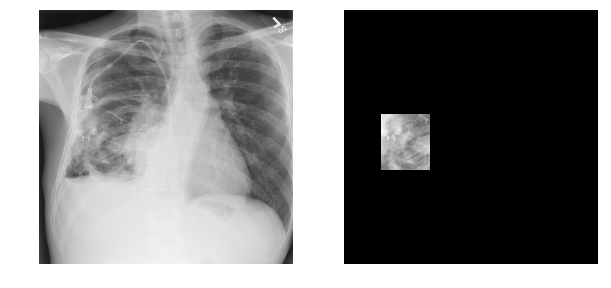

In [19]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
    
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

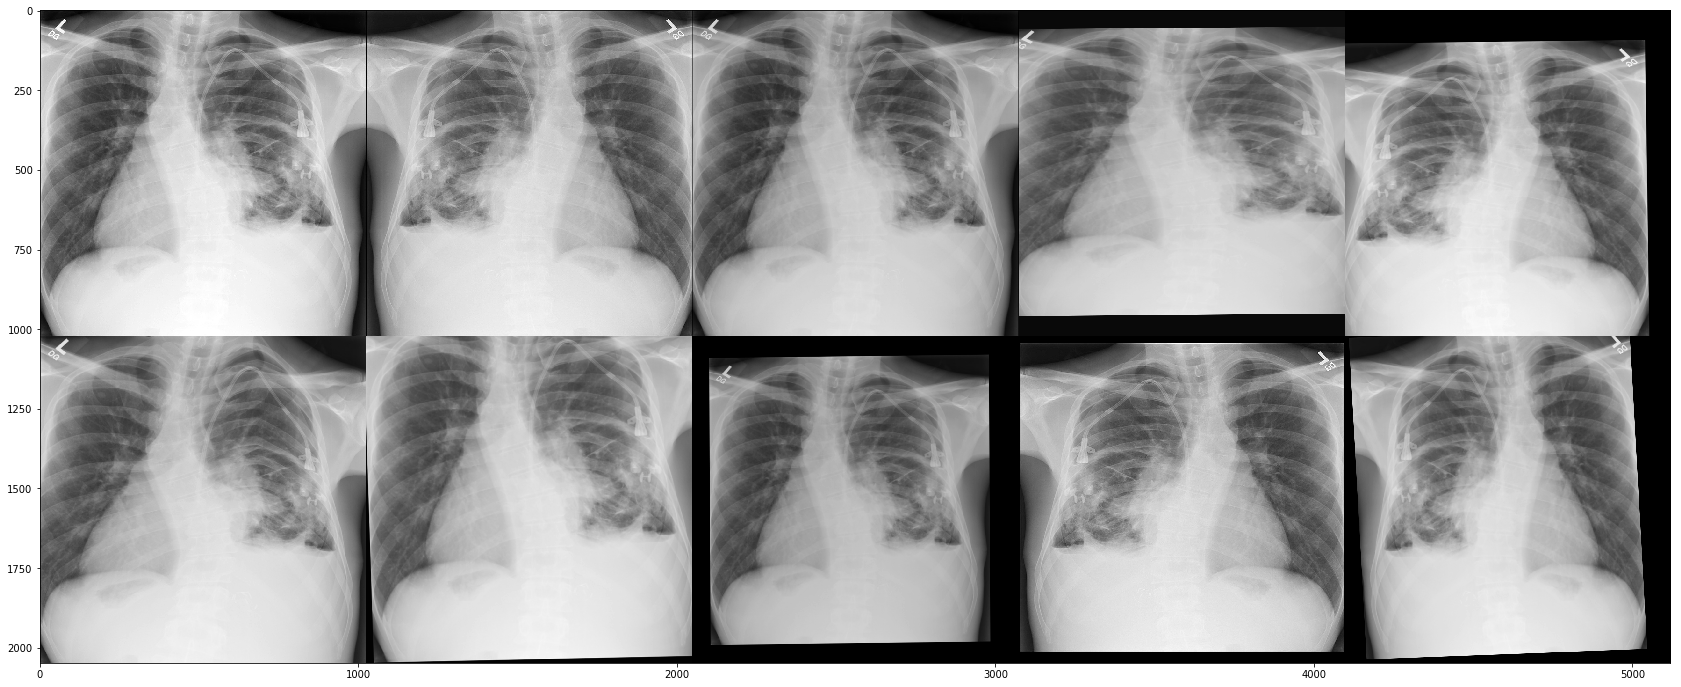

In [20]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Image augmentation (heavy and random)
augmentation = iaa.Sequential([
    # flip left/right 50% of time
    iaa.Fliplr(0.5),
    iaa.Sequential([
        iaa.OneOf([ ## geometric transform
            iaa.Affine(
                scale={"x": (0.85, 1.15), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.08, 0.08)},
                rotate=(-2.5, 2.5),
                shear=(-1.5, 1.5),
            ),
            iaa.PiecewiseAffine(scale=(0.005, 0.075)),
            iaa.Noop(),
        ]),
        iaa.OneOf([
            iaa.Crop(px=(0, 50)),
            iaa.Pad(px=(0, 50)),
            iaa.Noop(),
        ]),
    ], True),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.75, 1.25)),
        iaa.Add((-20, 20)),
        iaa.Noop(),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.4)),
        iaa.Sharpen(alpha=(0.0, 0.4)),
        iaa.Noop(),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

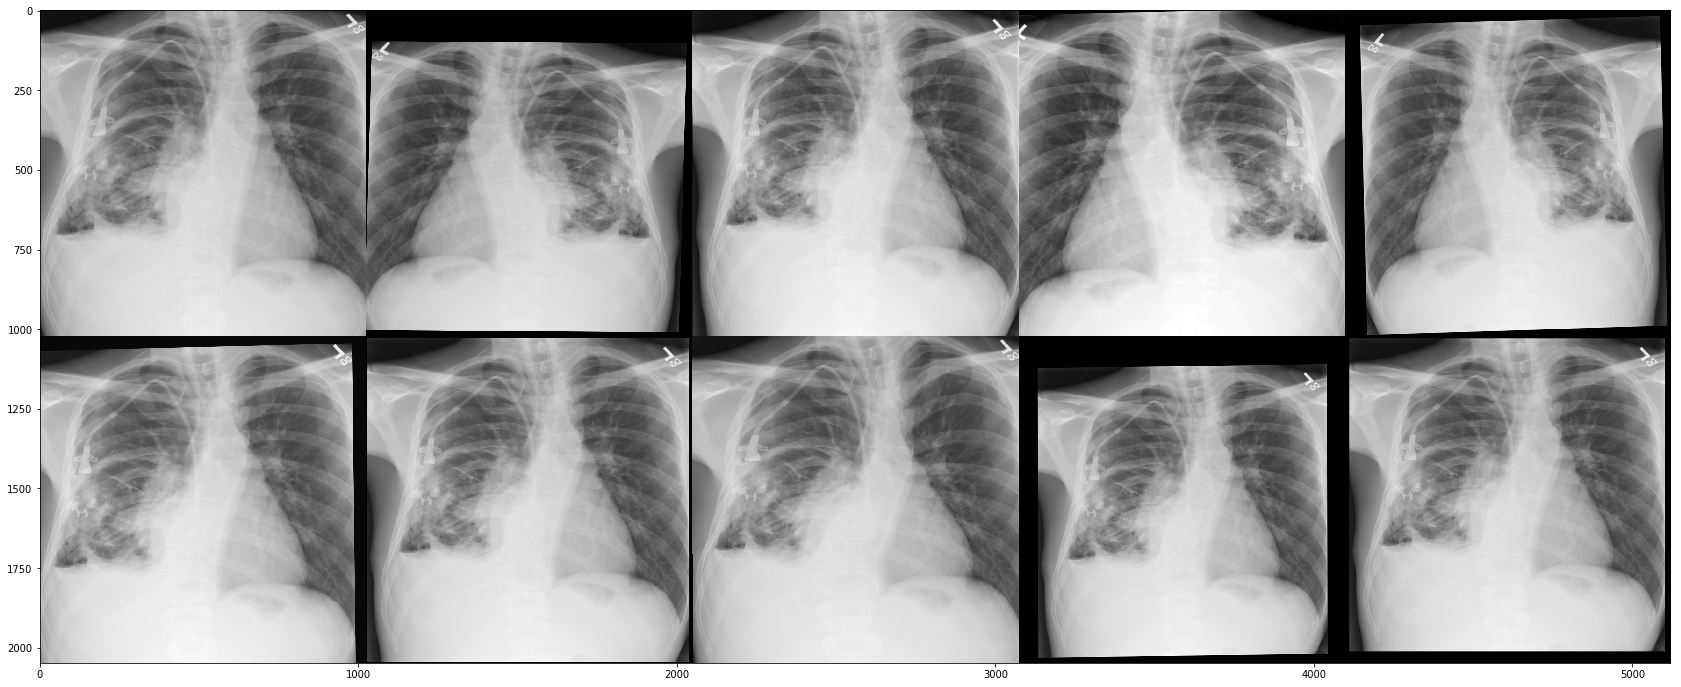

In [21]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Image augmentation (heavy and random)
augmentation1 = iaa.Sequential([
    # flip left/right 50% of time
    iaa.Fliplr(0.5),
    iaa.Sequential([
        iaa.OneOf([ ## geometric transform
            iaa.Affine(
                scale={"x": (0.85, 1.15), "y": (0.85, 1.15)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.08, 0.08)},
                rotate=(-2, 2),
                shear=(-1.5, 1.5),
            ),
            iaa.PiecewiseAffine(scale=(0.005, 0.05)),
            iaa.Noop(),
        ]),
        iaa.OneOf([
            iaa.Crop(px=(0, 40)),
            iaa.Pad(px=(0, 40)),
            iaa.Noop(),
        ]),
    ], True),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.75, 1.25)),
        iaa.Add((-20, 20)),
        iaa.Noop(),
    ]),
])

# test on the same image as above
imggrid = augmentation1.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

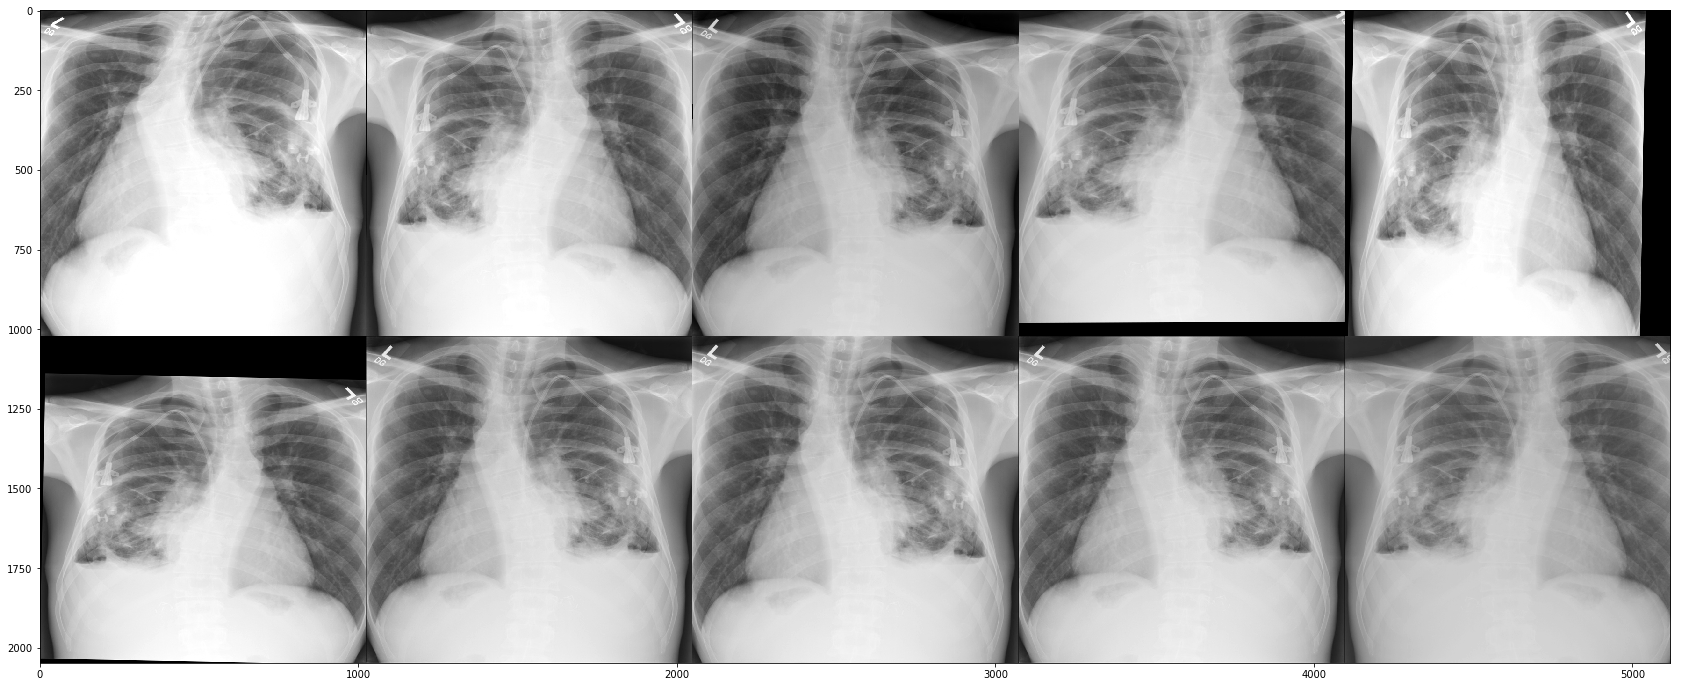

In [22]:
# Image augmentation (heavy and random)
augmentation2 = iaa.Sequential([
    # flip left/right 50% of time
    iaa.Fliplr(0.5),
    iaa.Sequential([
        iaa.OneOf([ ## geometric transform
            iaa.Affine(
                scale={"x": (0.85, 1.15), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.08, 0.08)},
                rotate=(-2.5, 2.5),
                shear=(-1.5, 1.5),
            ),
            iaa.PiecewiseAffine(scale=(0.005, 0.075)),
            iaa.Noop(),
        ]),
        iaa.OneOf([
            iaa.Crop(px=(0, 35)),
            iaa.Pad(px=(0, 35)),
            iaa.Noop(),
        ]),
    ], True),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.75, 1.25)),
        iaa.Add((-20, 20)),
        iaa.Noop(),
    ]),
])

# test on the same image as above
imggrid = augmentation2.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

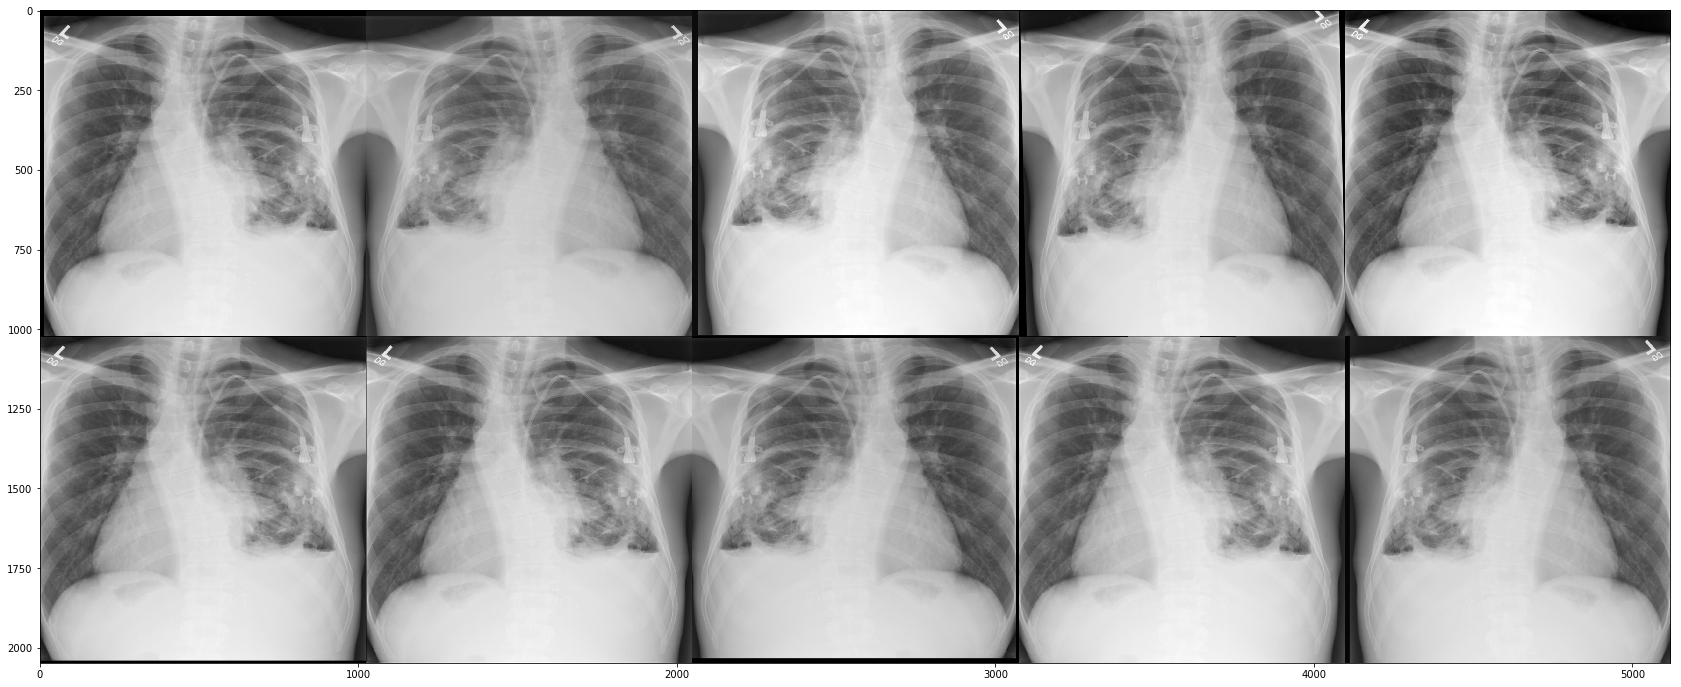

In [23]:
# Less augmentation to speed up training
augmentation3 = iaa.Sequential([
    # flip left/right 50% of time
    iaa.Fliplr(0.5),
    
    # crop or pad the image
    iaa.OneOf([
        iaa.CropAndPad(px=(-20, 20)),
        iaa.OneOf([ ## geometric transform
                iaa.Affine(
                    scale={"x": (0.95, 1.05), "y": (0.95, 1.08)},
                    translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
                    rotate=(-2, 2),
                    shear=(-1, 1),
                ),
                iaa.PiecewiseAffine(scale=(0.001, 0.025)),
                iaa.Noop(),
            ]),
        ]),
    # blur or sharpen
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.75, 1.25)),
        iaa.Add((-20, 20)),
        iaa.Noop(),
    ]),
], True)

# test on the same image as above
imggrid = augmentation3.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [24]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# try to load the latest checkpoint, if there is a problem initialize with the coco weights instead
try:    
    # find the most recent checkpoint
    checkpoint = model.find_last()
    checkpoint = "/home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0043.h5"
    print("Loading weights from:", checkpoint)

    # load the previous weights
    model.load_weights(checkpoint)
    
    # get the current epoch from the path
    current_epoch = int(checkpoint.split("_")[-1].split(".")[0])
    print("Epoch:", current_epoch)
    # set the current epoch 
    model.epoch = current_epoch
except:
    # Exclude the last layers because they require a matching
    # number of classes
    print("Error loading weights, initializing with COCO")
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])
    
LEARNING_RATE = 0.004

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

Loading weights from: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0043.h5
Epoch: 43


In [ ]:
%%time
## train heads with higher lr and no augmentation to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE * 2,
            epochs=4,
            layers='heads',
            augmentation=None)  ## no need to augment yet

In [ ]:
%%time
# train heads with no augmentation and lower lr for 4 more epochs
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='heads',
            augmentation=None)

In [ ]:
%%time
# train heads for 2 more epochs with augmentation
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=8,
            layers='heads',
            augmentation=augmentation)

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=12,
            layers='5+',
            augmentation=augmentation)

In [21]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/4,
            epochs=16,
            layers='all',
            augmentation=augmentation)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 12. LR=0.001

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 13/16
500/500 [==============================] - 2865s 6s/step - loss: 1.2019 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2492 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.3364 - mrcnn_mask_loss: 0.3643 - val_loss: 1.1268 - val_rpn_class_loss: 0.0160 - val_rpn_bbox_loss: 0.2270 - val_mrcnn_class_loss: 0.2204 - val_mrcnn_bbox_loss: 0.3199 - val_mrcnn_mask_loss: 0.3434

Epoch 00013: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0013.h5
Epoch 14/16
500/500 [==============================] - 2343s 5s/step - loss: 1.1856 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2434 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.3325 

In [22]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/6,
            epochs=20,
            layers='all',
            augmentation=augmentation)


Starting at epoch 16. LR=0.0006666666666666666

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 17/20
500/500 [==============================] - 2879s 6s/step - loss: 1.1313 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.2032 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.3603 - val_loss: 1.1152 - val_rpn_class_loss: 0.0149 - val_rpn_bbox_loss: 0.2545 - val_mrcnn_class_loss: 0.1760 - val_mrcnn_bbox_loss: 0.3251 - val_mrcnn_mask_loss: 0.3445

Epoch 00017: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0017.h5
Epoch 18/20
500/500 [==============================] - 2494s 5s/step - loss: 1.1173 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.1995 - mrcnn_bbox_loss: 0.3168 - mrcnn_mask_loss: 0.3592 - val_loss: 1.0892 - val_rpn_cl

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/8,
            epochs=24,
            layers='all',
            augmentation=augmentation)


Starting at epoch 20. LR=0.0005

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 21/24
500/500 [==============================] - 2882s 6s/step - loss: 1.0842 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.1914 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.3550 - val_loss: 1.0753 - val_rpn_class_loss: 0.0144 - val_rpn_bbox_loss: 0.2540 - val_mrcnn_class_loss: 0.1685 - val_mrcnn_bbox_loss: 0.2987 - val_mrcnn_mask_loss: 0.3397

Epoch 00021: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0021.h5
Epoch 22/24
500/500 [==============================] - 2448s 5s/step - loss: 1.0810 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2186 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 0.3551 - val_loss: 1.1027 - val_rpn_class_loss: 0.014

In [26]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/12,
            epochs=28,
            layers='all',
            augmentation=augmentation)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 22. LR=0.0003333333333333333

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 23/28
500/500 [==============================] - 3065s 6s/step - loss: 1.0866 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.1890 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 0.3559 - val_loss: 1.0139 - val_rpn_class_loss: 0.0114 - val_rpn_bbox_loss: 0.1899 - val_mrcnn_class_loss: 0.1883 - val_mrcnn_bbox_loss: 0.2915 - val_mrcnn_mask_loss: 0.3328

Epoch 00023: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0023.h5
Epoch 24/28
500/500 [==============================] - 2352s 5s/step - loss: 1.0763 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.1873 - mrcnn_bb

In [37]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/16,
            epochs=32,
            layers='all',
            augmentation=augmentation)


Starting at epoch 28. LR=0.00025

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 29/32
500/500 [==============================] - 3022s 6s/step - loss: 1.0480 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.1783 - mrcnn_bbox_loss: 0.2940 - mrcnn_mask_loss: 0.3530 - val_loss: 1.0300 - val_rpn_class_loss: 0.0128 - val_rpn_bbox_loss: 0.1942 - val_mrcnn_class_loss: 0.1862 - val_mrcnn_bbox_loss: 0.2987 - val_mrcnn_mask_loss: 0.3381

Epoch 00029: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0029.h5
Epoch 30/32
500/500 [==============================] - 2539s 5s/step - loss: 1.0538 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.1825 - mrcnn_bbox_loss: 0.2969 - mrcnn_mask_loss: 0.3544 - val_loss: 1.0108 - val_rpn_class_loss: 0.01

In [21]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/20,
            epochs=36,
            layers='all',
            augmentation=augmentation)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 31. LR=0.0002

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 32/36
500/500 [==============================] - 2925s 6s/step - loss: 1.0491 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.1775 - mrcnn_bbox_loss: 0.2946 - mrcnn_mask_loss: 0.3537 - val_loss: 0.9999 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.2009 - val_mrcnn_class_loss: 0.1667 - val_mrcnn_bbox_loss: 0.2874 - val_mrcnn_mask_loss: 0.3337

Epoch 00032: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0032.h5
Epoch 33/36
500/500 [==============================] - 2322s 5s/step - loss: 1.0588 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2132 - mrcnn_class_loss: 0.1785 - mrcnn_bbox_loss: 0.2992

In [32]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/24,
            epochs=40,
            layers='all',
            augmentation=augmentation)


Starting at epoch 36. LR=0.00016666666666666666

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 37/40
500/500 [==============================] - 2924s 6s/step - loss: 1.0445 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2065 - mrcnn_class_loss: 0.1764 - mrcnn_bbox_loss: 0.2952 - mrcnn_mask_loss: 0.3537 - val_loss: 0.9992 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.2132 - val_mrcnn_class_loss: 0.1525 - val_mrcnn_bbox_loss: 0.2842 - val_mrcnn_mask_loss: 0.3376

Epoch 00037: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0037.h5
Epoch 38/40
500/500 [==============================] - 2506s 5s/step - loss: 1.0388 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.2922 - mrcnn_mask_loss: 0.3523 - val_loss: 0.9948 - val_rpn_c

In [22]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/20,
            epochs=43,
            layers='all',
            augmentation=augmentation)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 41. LR=0.0002

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 42/43
1480/1480 [==============================] - 5661s 4s/step - loss: 1.0242 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2025 - mrcnn_class_loss: 0.1728 - mrcnn_bbox_loss: 0.2872 - mrcnn_mask_loss: 0.3494 - val_loss: 0.9750 - val_rpn_class_loss: 0.0114 - val_rpn_bbox_loss: 0.1862 - val_mrcnn_class_loss: 0.1784 - val_mrcnn_bbox_loss: 0.2711 - val_mrcnn_mask_loss: 0.3280

Epoch 00042: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0042.h5
Epoch 43/43
1480/1480 [==============================] - 5159s 3s/step - loss: 1.0112 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.

In [39]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/12,
            epochs=45,
            layers='all',
            augmentation=augmentation3)


Starting at epoch 43. LR=0.0003333333333333333

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 44/45
1417/1417 [==============================] - 4131s 3s/step - loss: 0.9901 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1999 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.2754 - mrcnn_mask_loss: 0.3367 - val_loss: 0.9740 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.2017 - val_mrcnn_class_loss: 0.1580 - val_mrcnn_bbox_loss: 0.2722 - val_mrcnn_mask_loss: 0.3305

Epoch 00044: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0044.h5
Epoch 45/45
1417/1417 [==============================] - 3564s 3s/step - loss: 0.9614 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.1574 - mrcnn_bbox_loss: 0.2681 - mrcnn_mask_loss: 0.3330 - val_loss: 0.9840 - val_rp

OSError: Unable to create file (unable to truncate a file which is already open)

In [51]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/12,
            epochs=47,
            layers='all',
            augmentation=augmentation1)


Starting at epoch 43. LR=0.0003333333333333333

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 44/47
1417/1417 [==============================] - 5355s 4s/step - loss: 1.0249 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.3480 - val_loss: 1.0087 - val_rpn_class_loss: 0.0122 - val_rpn_bbox_loss: 0.2163 - val_mrcnn_class_loss: 0.1552 - val_mrcnn_bbox_loss: 0.2857 - val_mrcnn_mask_loss: 0.3393

Epoch 00044: saving model to /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0044.h5
Epoch 45/47
1417/1417 [==============================] - 4988s 4s/step - loss: 1.0022 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.3459 - val_loss: 1.0250 - val_rp

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/12,
            epochs=50,
            layers='all',
            augmentation=augmentation)


Starting at epoch 47. LR=0.0003333333333333333

Checkpoint Path: /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_{epoch:04d}.h5
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
Epoch 48/50
 346/1417 [======>.......................] - ETA: 1:20:40 - loss: 1.0252 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.2071 - mrcnn_class_loss: 0.1718 - mrcnn_bbox_loss: 0.2808 - mrcnn_mask_loss: 0.3523

Process Process-51:
Process Process-50:
Process Process-47:
Process Process-48:
Process Process-53:
Process Process-54:
Process Process-52:
Process Process-49:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py

  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
KeyboardInterrupt
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 1522, in _augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 1514, in _augment_images
    hooks=hooks
  File "/home/eric/.local/lib/python3.5/site-packages/pydicom/dataset.py", line 815, in convert_pixel_data
    arr = handler.get_pixeldata(self)
  File "/home/eric/.local/lib/python3.5/site-packages/pydicom/pixel_data_handlers/pillow_handler.py", line 200, in get_pixeldata
    UncompressedPixelData.extend(decompressed_image.tobytes())
  File "/home/eric/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 431, in augment_images
    hooks=hooks
  File "/ho

  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<string>", line 2, in put
  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line 2, in put
  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "/home/eric/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line

In [ ]:
%%time
model.train(dataset_all, dataset_val,
            learning_rate=LEARNING_RATE/32,
            epochs=50,
            layers='all',
            augmentation=augmentation)

In [52]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0047.h5


In [53]:
# model_path = "/home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0043.h5"

In [54]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model_inf = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# model_path = "/content/working/pneumonia/mask_rcnn_pneumonia_0018.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model_inf.load_weights(model_path, by_name=True)

Loading weights from  /home/eric/pneumonia/working/pneumonia320/mask_rcnn_pneumonia320_0047.h5


In [55]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

In [56]:
# calculate IOU where there can be multiple overlapping truths and predictions
def calc_iou_better(y_true, y_pred, image_size=1024):
    label_array = np.zeros((image_size, image_size))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for truth in y_true:
        x,y,w,h = truth[:4].astype(int)  
        label_array[y:y+h, x:x+w] = 1
                
    pred_array = np.zeros((image_size, image_size))
    for pred in y_pred:
        x,y,w,h = pred[:4].astype(int)

        # update the pixels
        pred_array[y:y+h, x:x+w] = 1
                
    true_area = np.sum(label_array)
    pred_area = np.sum(pred_array)
    
    intersect_area = np.sum((pred_array == 1) & (label_array == 1))
    
    union = true_area + pred_area - intersect_area
    
    iou = intersect_area / (union + 1e-6)
    
    return iou   

(320, 320, 3)

*** No instances to display *** 

(320, 320, 3)
(320, 320, 3)

*** No instances to display *** 

(320, 320, 3)

*** No instances to display *** 

(320, 320, 3)

*** No instances to display *** 

(320, 320, 3)

*** No instances to display *** 

Mean IOU: 0.10592659323115454


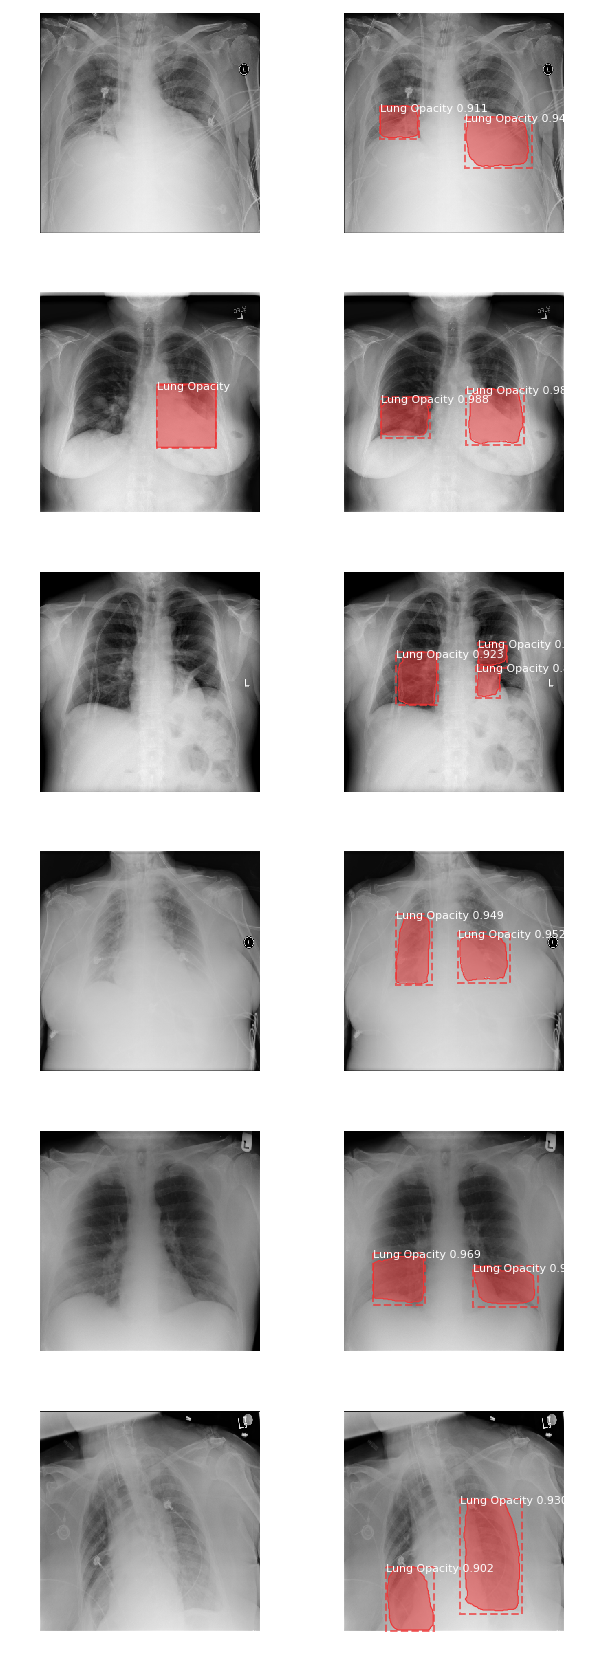

In [57]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))
iou_scores = []

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model_inf.detect([original_image])
    r = results[0]
    
    if len(r['rois']) or len(gt_bbox):
        iou = calc_iou_better(gt_bbox, r['rois'], 384)
        iou_scores.append(iou)
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    
print("Mean IOU:", np.mean(iou_scores))   

In [58]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [59]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model_inf.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [60]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [09:39<00:00,  5.18it/s]

/home/eric/pneumonia/working/submission.csv


In [61]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f {submission_fp} -m "mask-rcnn GCP 320x320 stage 2 47 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [62]:
del(model_inf)

In [ ]:
# show a few test image detection example
def visualize2(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize2()
visualize2()
visualize2()
visualize2()